In [51]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [52]:
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

In [53]:
from __future__ import print_function
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.integrate import quad,simps
import os,sys
import random
sys.path.append('../')
import hmvec as hm # Git clone and pip install as in readme from github.com/msyriac/hmvec
import numpy as np
import scipy.constants as constants
import scipy

from scipy.special import legendre
from scipy.special import spherical_jn

In [54]:
#dirplots = '/home/dpirvu/dark-photon/code/examples/plots/'
dirplots = '/home/dpirvu/dark-photon/code/examples/'

In [55]:
# From hmvec:
# r is always in Mpc
# k is always in Mpc-1
# All rho densities are in Msolar/Mpc^3
# All masses m are in Msolar
# No h units anywhere

cmMpc = 3.24e-25               # Mpc/cm            # how many Mpc in a cm
eVinvCm = 1.24e-4              # cm/eV^-1          # how many cm in a eV^-1
mpcEVinv = 1./(cmMpc*eVinvCm)  # eV^-1/Mpc         # how many eV^-1 in a Mpc
print(mpcEVinv)

msun = 1.9891e30     # kg                # Sun mass
mprot = 1.6e-27      # kg                # Proton mass
m2eV = 1.4e-21       # eV^2              # conversion factor for plasma mass (eq. (2) in Caputo et al; PRL)
ombh2 = 0.02225                          # Physical baryon density parameter Ωb h2
omch2 = 0.1198                           # Physical dark matter density parameter Ωc h2
MA = 10.**(-12.)                         # Mass of dark photon
omega0 = 30*4.1e-6                       # photon frequency today in eV

# halo mass is mostly dark matter;
# plasmon gets mass through interactions with electrons only
# However, since halos are electically neutral, #electrons = #protons
# The total baryonic mass is well approximated by the total mass of protons
# From PRL, eq(2), the plasma mass is equal to
# mass^2 = (1.4e-21 ev^2) * n_e / cm^-3
# This is the conversion factor between the halo density and the mass of plasma
conv = m2eV*(ombh2/omch2)*(msun/mprot)*(cmMpc)**3
print('Alpha, conversion factor', conv)

# Photon frequency at z:
omegaz = lambda z: omega0/aa(z)

2.489048187972919e+28
Alpha, conversion factor 1.09944345509399e-38


In [56]:
# Produces halo model with following parameters
nMasses=100
nZs=10

zs = np.linspace(0.01,4.,nZs)          # redshifts
ms = np.geomspace(1e7,1e17,nMasses)      # masses
ks = np.geomspace(1e-4,100,1001)         # wavenumbers

# Mass function returns bias factor and halo mass function f(nu)
# from the nu f(nu) one can get the halo collapse fraction f(sigma, z) (eq.(B7) in Matt's paper appendix)
# although I guess here the important function of nu f(nu) is eq.(56) in the review
# Tinker seems to be the modern, more flexible fit (see Tinker et al. 2010)
#
# mdef ='vir' means determines how the radius of the halo is computed from the mass;
# there is a factor Delta that multiplies the background density which comes into the integral over the sphere volume
# if mdef='mean', Delta is taken to be 200, but otherwise it is calculated according to fit by Bryan & Normal 1997
hcos = hm.HaloModel(zs, ks, ms=ms, mass_function='tinker', mdef='vir')

# Get concentrations of every halo within model
cs=hcos.concentration()
# cs has dimensions (nZs, nMasses)
print(cs.shape)

(10, 100)


proper distance to halo: 44 Mpc 
virial radius 12 Mpc


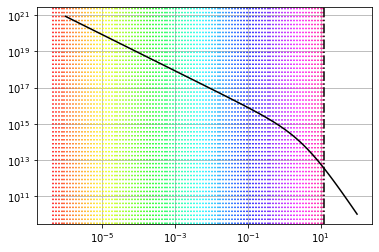

$\Delta n = 67542.4$ arcseconds
min photon radius 14.408230543704368 Mpc
Maximum angle error of approximation 0.0058206917390111745


In [57]:
# Test small angle approximation for biggest halo in the sky:
zsindex = 0#nZs-1
msindex = nMasses-1

rvir = hcos.rvir(ms[msindex],zs[zsindex])
rss = rvir/cs[zsindex,msindex]
nfw_rhoscsale = hm.rhoscale_nfw(ms[msindex],rvir,cs[zsindex,msindex])
rs=np.geomspace(.000001, 100, 100)
nfw_profile = hm.rho_nfw(rs,nfw_rhoscsale,rss)

#compute proper distance
chi = hcos.comoving_radial_distance(zs[zsindex]) #from CAMB
aa = lambda z: 1./(1.+z)
dphys = chi * aa(zs[zsindex]) #in Mpc

# scan over theta angle (radians):
deltaN = np.geomspace(.00000001, 1, 100)
rad2arcs = 206264.806247

cmap = get_cmap(len(deltaN))
print('proper distance to halo:', int(dphys), 'Mpc \nvirial radius', int(rvir[0]), 'Mpc')
for i, dn in enumerate(deltaN):
    rmin = dn * dphys
    if rmin < rvir[0]:
        #print(dn, '\t\t\t', rmin/rvir[0], '\t\t',np.abs(np.sin(dn)-dn))
        plt.axvline(rmin, ls=':', color=cmap(i))
    else:
        break
# Plot halo profile
plt.loglog(rs, nfw_profile, color='k')
# Plot virial radius
plt.axvline(rvir[0], ls='-.', color='k')
plt.grid(); plt.show()
print(r'$\Delta n = {:.1f}$'.format(dn*rad2arcs), 'arcseconds')
print('min photon radius', rmin, 'Mpc')
print('Maximum angle error of approximation', np.abs(np.sin(dn)-dn))

In [58]:
# Choose one single halo for the analysis below
zsindex = nZs-1
msindex = nMasses-1

# rvir returns radius of sphere with mass m given in terms of the
# critical density of the universe at redshift z (function of Hubble parameter & cosmology)
# and a multiplying factor Delta usually 200 (see equation (1) of Tinker et al. 2010)
rvir = hcos.rvir(ms[msindex],zs[zsindex])
# rss is the fit parameter in the NFW profile function r_s
# which is the location of the turning point in the NFW density profile
rss = (rvir/cs[zsindex,msindex])

# this gives the rho_s parameter of the NFW function from the mass constraint (see eq. (76) in review)
# total mass = integral from zero to virial radius over the profile
nfw_rhoscsale = hm.rhoscale_nfw(ms[msindex],rvir,cs[zsindex,msindex])

# generate halo radius list
rs=np.linspace(1e-4,50,1000000) 
# using rho_s from the mass constraint, and the turning point predicted by the chosen m and z of the halo,
# generate rho(r), for r in list rs
nfw_profile = hm.rho_nfw(rs,nfw_rhoscsale,rss)

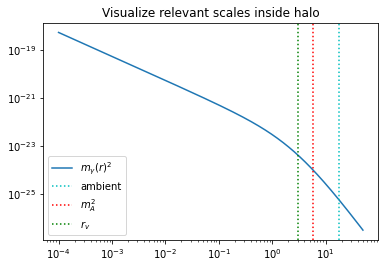

In [59]:
plt.title('Visualize relevant scales inside halo')
plt.loglog(rs, conv * nfw_profile, label=r'$m_\gamma(r)^2$')  # plasma mass^2 
plt.axvline(rs[np.argmin(np.abs(conv*hcos.rho_matter_z(zs[zsindex])-conv*nfw_profile))], ls=':', color='c', label=r'ambient')  # mass^2 of the A'
plt.axvline(rs[np.argmin(np.abs(conv*nfw_profile-MA**2.))], ls=':', color='r', label=r'$m_A^2$')  # mass^2 of the A'
plt.axvline(rvir, ls=':', color='g', label=r'$r_v$')
plt.legend()
plt.savefig(dirplots+'haloscales.pdf')
plt.show()
# Resonant conversion happens when the plasma mass^2 = mass^2 of the A'.
# In this example (large z, small m), the ambient plasma mass is above resonant dark photon mass

[0, 3, 2, 6, 8]
[64, 71, 38, 17, 20]


/tmp/ipykernel_56890/3426417847.py:15: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(dirplots+'haloexamples.pdf')
/tmp/ipykernel_56890/3426417847.py:15: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(dirplots+'haloexamples.pdf')
/home/dpirvu/.conda/envs/conda_env/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


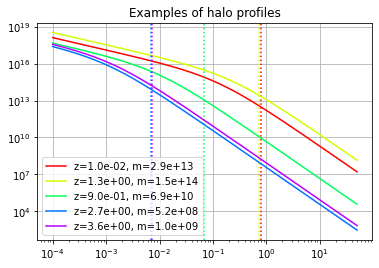

In [60]:
zindices = random.sample(range(nZs), 5); print(zindices)
msindices = random.sample(range(nMasses), 5); print(msindices)

cmap = get_cmap(len(zindices)+1)
for i, (zsindex, msindex) in enumerate(zip(zindices, msindices)):
    rvir = hcos.rvir(ms[msindex],zs[zsindex])
    rss = rvir/cs[zsindex,msindex]
    nfw_rhoscsale = hm.rhoscale_nfw(ms[msindex],rvir,cs[zsindex,msindex])

    nfw_profile = hm.rho_nfw(rs, nfw_rhoscsale, rss)
    plt.loglog(rs, nfw_profile, label='z={:.1e}'.format(zs[zsindex])+', m={:.1e}'.format(ms[msindex]), color=cmap(i))
    plt.axvline(rvir[0], ls=':', color=cmap(i))
plt.title('Examples of halo profiles')
plt.legend(); plt.grid()
plt.savefig(dirplots+'haloexamples.pdf')
plt.show()

In [61]:
# Compute all crossing radii in this halo model
nMasses=200
nZs=5
zs = np.linspace(0.01,1.,nZs) # redshifts
ms = np.geomspace(1e7,1e17,nMasses) # masses
ks = np.geomspace(1e-4,100,1001) # wavenumbers
rs=np.linspace(1e-4,100,1000000) 

hcos = hm.HaloModel(zs, ks, ms=ms, mass_function='tinker', mdef='vir')
cs=hcos.concentration()

In [62]:
rcross=np.zeros((nZs,nMasses))     # Array for radius where plasma mass^2 = A' mass^2
drhodr=np.zeros((nZs,nMasses))     # Array for derviative of density wrt r.
prob=np.zeros((nZs,nMasses))       # Array for optical depth per halo due to A' conversion.

for zi in range(nZs):                  # Loop through redshifts; keeping all masses
    rvir = hcos.rvir(ms,zs[zi])        
    rss = rvir/cs[zi]
    nfw_rhoscsales = hm.rhoscale_nfw(ms, rvir, cs[zi])
    nfw_profiles = np.asarray([hm.rho_nfw(rs, nfw_rhoscsales[mi], rss[mi]) for mi in range(nMasses)])
    
    # Find the index of the radius array where plasmon mass^2 = dark photon mass^2
    idx = np.argmin(np.abs(conv*nfw_profiles - MA**2), axis=1)

    # Fill the array with crossing radii
    rcross[zi] = rs[idx]
    # d m_gamma^2 / dr evaluated where plasma mass^2 = A' mass^2
    rfr = rcross[zi]/rss
    drhodr[zi] = conv*(nfw_rhoscsales/rss)*(1+3.*rfr)/(rfr)**2./(1+rfr)**3.

    # Conversion probability per halo
    # The crossing radius should be rcross < r_virEnsure this with Heaviside function
    prob[zi] = mpcEVinv*np.pi*MA**4.*np.heaviside(rvir-rcross[zi], 0.5)/omegaz(zs[zi])/drhodr[zi]

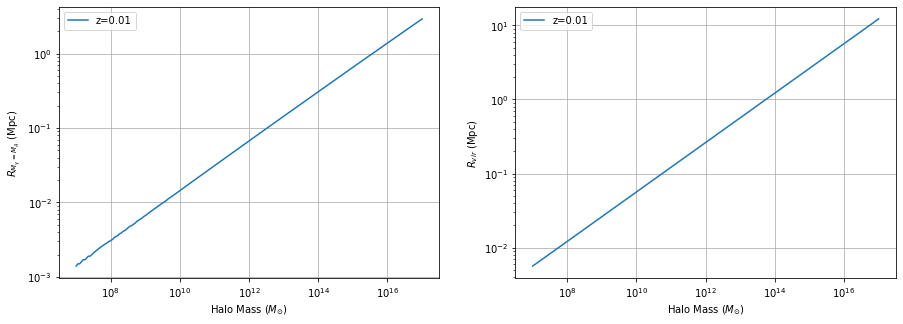

In [63]:
# Visualize properties of crossing radii
# Crossing radius increases with increasing redshift
# Virial radius decreases

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
for zi in range(0, nZs, 5):
    ax[0].loglog(ms, rcross[zi], label='z={:.2f}'.format(zs[zi]))
    ax[1].loglog(ms, hcos.rvir(ms, zs[zi]), label='z={:.2f}'.format(zs[zi]))
[i.grid() for i in ax]
[i.legend() for i in ax]
[i.set_xlabel('Halo Mass ($M_{\odot}$)') for i in ax]
ax[0].set_ylabel('$R_{M_\gamma = M_A}$ (Mpc)')
ax[1].set_ylabel('$R_{vir}$ (Mpc)')
plt.show()

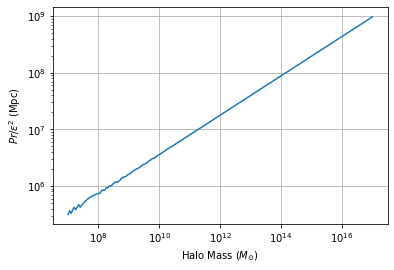

In [64]:
# The conversion probability / epsilon^2 per halo at fixed redshift.
for zi in range(0, nZs, 5):
    plt.loglog(ms, prob[zi])
plt.xlabel('Halo Mass ($M_{\odot}$)')
plt.ylabel('$Pr / \epsilon^2$ (Mpc)')
plt.grid()

integral \dd{m} n(z,m) [54.87147028248799, 59.0952046545308, 63.15377056809191, 66.90857346205318, 70.28196576052608]


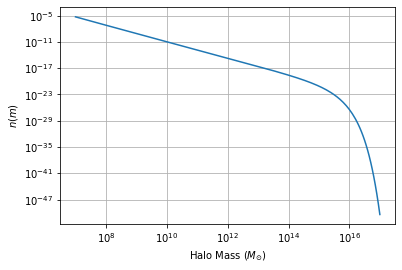

In [65]:
# Halo number density function of mass, fixed redshift
nzm = hcos.get_nzm()
print('integral \dd{m} n(z,m)', [np.trapz(nzm[z], ms) for z in range(nZs)])

for zi in range(0, nZs, 5):
    plt.loglog(ms, nzm[zi,:])
#plt.ylim(1e-50,1e-3)
plt.xlabel('Halo Mass ($M_{\odot}$)')
plt.ylabel(r'$n(m)$')
plt.grid()
plt.savefig(dirplots+'nzm.pdf')
plt.show()

In [66]:
# Mean probability per redshift bin
onepf = np.asarray([np.trapz(nzm[zi]*prob[zi], ms) for zi in range(nZs)])

# Proper distance to redshift z
dchi = np.outer(hcos.comoving_radial_distance(zs)*aa(zs), np.ones(ms.shape)) #in Mpc # dimensions:(nZs,nMasses)
# Normalization of angular function u(theta,phi)
norm = dchi*rcross/np.pi/(dchi * rcross - (dchi**2.-rcross**2.)*np.arctanh(rcross/dchi))
# Upper limit on theta integral which ensures second heaviside step function (namely r_cross <= r_conv)
thetaMax = np.arcsin(rcross/dchi)
thetaLists = np.asarray([[np.linspace(0, thetaMax[zi,mi], 200) for mi in range(nMasses)] for zi in range(nZs)])

# angular dependence u(theta)
uu = lambda theta, z, m: norm[z,m] * np.sqrt(1. - (np.sin(theta)*dchi[z,m]/rcross[z,m])**2.)
# check its normalization numerically
# recall heaviside step function is here implemented by integrating only up to theta = arcsin(rc/dchi)
# such that the value of the function at larger angle is automatically set to 0
uudn = lambda theta, z, m: 2.*np.pi*np.sin(theta) * uu(theta, z, m)
Yell = lambda theta, ell: np.sqrt((2.*ell+1)/4./np.pi)*legendre(ell)(np.cos(theta)) # Yellem where m=0
duelldtheta = lambda theta, ell, z, m: Yell(theta, ell)*uudn(theta, z, m) # project u function over spherical harmonic
# the 2 comes from crossing twice over the resonant band

uell0 = lambda ell, z, m: 2.*quad(duelldtheta, 0, thetaMax[z, m], args=(ell, z, m))[0]
#uell0 = lambda ell, z, m: 2.*np.trapz(np.asarray([duelldtheta(theta, ell, z, m) for theta in thetaLists[z,m]]), thetaLists[z,m])

num1h = lambda ell, z: np.trapz(nzm[z]*prob[z]**2.*np.abs(np.asarray([uell0(ell,z,m) for m in range(nMasses)]))**2., ms)
Cell1h = lambda ell, z: 4.*np.pi/(2.*ell+1) * num1h(ell, z) / onepf[z]**2.

# linear matter power spectrum P(k)
# what is this?
#     try: self.as8 = self.params['as8']        
#     except: self.as8 = 1
# does it need a filter?
PzkLin = hcos._get_matter_power(zs, ks, nonlinear=False)
# Biases for each halo
biases = hcos.get_bh()

# should it be multiplied by a filter?
dCellhhdk = lambda k, ell, z: 2./np.pi * PzkLin[z,k] * k**2. * spherical_jn(ell, ks[k]*dchi[z,0])**2.
Cellhh = lambda ell, z: np.trapz(np.asarray([dCellhhdk(k, ell, z) for k in range(len(ks))]), ks)

# The 2-halo contribution
num2h = lambda ell, z: np.trapz(nzm[z]*prob[z]*biases[z]*np.asarray([uell0(ell,z,m) for m in range(nMasses)]), ms)
Cell2h = lambda ell, z: 4.*np.pi/(2.*ell+1) * Cellhh(ell, z) * (num2h(ell,z) / onepf[z])**2.

In [68]:
ell_list = np.arange(1, 500, 1)
zindices = np.arange(nZs)[::10]; print('z`s:', zs[zindices])
mindices = [0, nMasses-1]; print('m`s:', ms[mindices])
msindex = 0; print('m`s:', ms[msindex])

z`s: [0.01]
m`s: [1.e+07 1.e+17]
m`s: 10000000.0


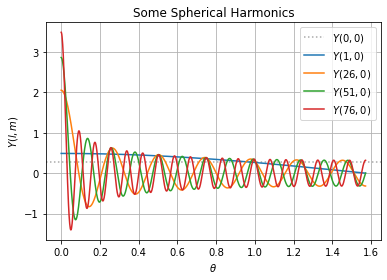

In [69]:
th_list = np.linspace(0, np.pi/2., 1000)
plt.axhline((4.*np.pi)**-0.5, ls=':', color='darkgray', label=r'$Y(0,0)$')
for ell in np.arange(1, 100, 25):
    plt.plot(th_list, Yell(th_list, ell), label=r'$Y($'+str(ell)+r'$,0)$')
plt.title('Some Spherical Harmonics')
plt.ylabel(r'$Y(l,m)$'); plt.xlabel(r'$\theta$')
plt.legend(); plt.grid(); plt.show()

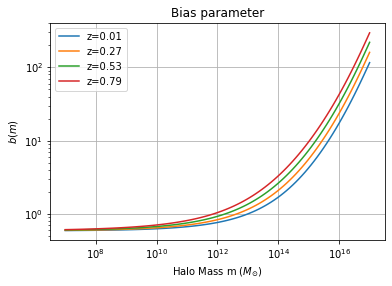

In [45]:
for zi in zindices:
    plt.loglog(ms, biases[zi,:], label='z={:.2f}'.format(zs[zi]))
plt.title('Bias parameter')
plt.xlabel('Halo Mass m ($M_{\odot}$)'); plt.ylabel(r'$b(m)$')
plt.legend(); plt.grid()
plt.savefig(dirplots+'biases.pdf')
plt.show()

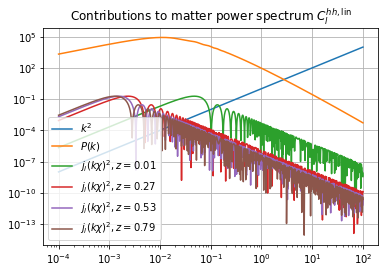

/tmp/ipykernel_56890/2925919415.py:12: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.loglog(llist, Clhh_list, label='z={:.2f}'.format(zs[zi]))


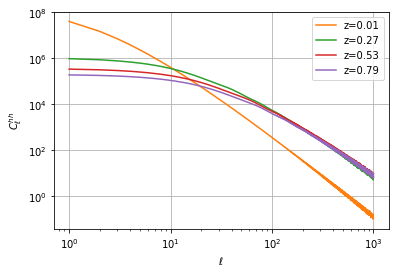

In [46]:
plt.title(r'Contributions to matter power spectrum $C_l^{hh, \mathrm{lin}}$')
plt.loglog(ks, ks**2., label=r'$k^2$')
plt.loglog(ks, PzkLin[0], label=r'$P(k)$')
for zi in zindices:
    plt.loglog(ks, spherical_jn(1, ks*dchi[zi,0])**2., label=r'$j_l(k \chi)^2, z={:.2f}$'.format(zs[zi]))
plt.legend(); plt.grid(); plt.show()

plt.plot('Matter angular power spectrum')
llist = np.arange(1, 1000, 1)
for zi in zindices:
    Clhh_list = np.asarray([Cellhh(ell, zi) for ell in llist])
    plt.loglog(llist, Clhh_list, label='z={:.2f}'.format(zs[zi]))
plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_\ell^{hh}$')
plt.legend(); plt.grid()
plt.savefig(dirplots+'matterpowspec.pdf')
plt.show()

No handles with labels found to put in legend.


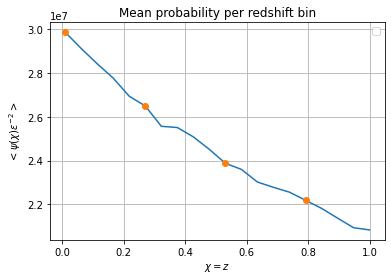

In [47]:
plt.title('Mean probability per redshift bin')
plt.plot(zs, [onepf[zi] for zi in range(nZs)])
plt.plot(zs[zindices], [onepf[zi] for zi in zindices], 'o')
plt.xlabel(r'$\chi=z$'); plt.ylabel(r'$<\psi(\chi)\epsilon^{-2}>$')
plt.legend(); plt.grid()
plt.savefig(dirplots+'meanprobperbin.pdf')
plt.show()

Normalization 1.0000000577283772
Normalization 0.9999999999999976
Normalization 0.9999645159965297
Normalization 0.9999999999905784
Normalization 0.9996636684845123
Normalization 0.9999999999406359
Normalization 1.0005773224497243
Normalization 0.9999999999706896


/tmp/ipykernel_56890/3374962570.py:13: RuntimeWarning: invalid value encountered in sqrt
  uu = lambda theta, z, m: norm[z,m] * np.sqrt(1. - (np.sin(theta)*dchi[z,m]/rcross[z,m])**2.)


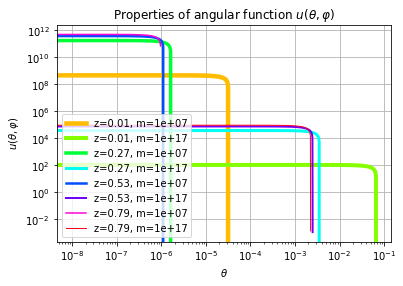

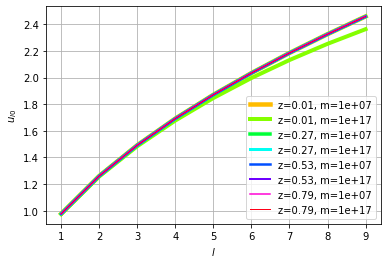

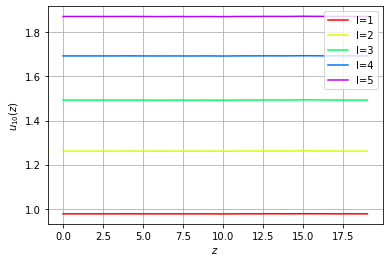

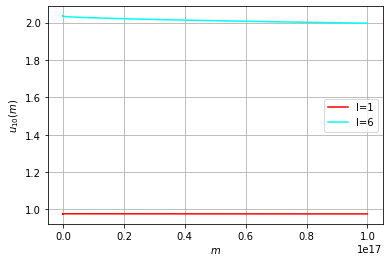

In [48]:
plt.title(r'Properties of angular function $u(\theta,\varphi)$')
cmap = get_cmap(len(zindices)*len(mindices)+1)
i=0
for zsindex in zindices:
    for mi in mindices:
        i+=1
        print('Normalization', quad(uudn, 0, thetaMax[zsindex, mi], args=(zsindex, mi))[0])
        th_list = np.linspace(0, thetaMax[zsindex,mi], 100)

        lab = 'z={:.2f}'.format(zs[zsindex])+', m={:.0e}'.format(ms[mi])
        plt.loglog(th_list, uu(th_list, zsindex, mi), color=cmap(i), linewidth=5-i*0.5, label=lab)
plt.xlabel(r'$\theta$')
plt.ylabel(r'$u(\theta,\varphi)$')
plt.legend(); plt.grid()
plt.savefig(dirplots + 'angularufuncexamples.pdf'); plt.show()

cmap = get_cmap(len(zindices)*len(mindices)+1)
i=0
for zsindex in zindices:
    for mi in mindices:
        i+=1
        lab = 'z={:.2f}'.format(zs[zsindex])+', m={:.0e}'.format(ms[mi])
        plt.plot(ell_list, [uell0(ell, zsindex, mi) for ell in ell_list], color=cmap(i), linewidth=5-i*0.5, label=lab)
plt.xlabel(r'$l$'); plt.ylabel(r'$u_{l0}$')
plt.legend(); plt.grid()
plt.savefig(dirplots + 'angularufuncvsell.pdf'); plt.show()

cmap = get_cmap(len(ell_list)+1)
for i, ell in enumerate(ell_list):
    plt.plot(zs, [uell0(ell, zs, msindex) for zs in range(nZs)], color=cmap(i), label='l='+str(ell))
plt.xlabel(r'$z$'); plt.ylabel(r'$u_{10}(z)$')
plt.legend(); plt.grid()
plt.savefig(dirplots + 'angularufuncvsredshift.pdf'); plt.show()

cmap = get_cmap(len(ell_list)+1)
zsindex = zindices[0]
for i, ell in enumerate(ell_list):
    plt.plot(ms, [uell0(ell, zsindex, msindex) for msindex in range(nMasses)], color=cmap(i), label='l='+str(ell))
plt.xlabel(r'$m$'); plt.ylabel(r'$u_{10}(m)$')
plt.legend(); plt.grid()
plt.savefig(dirplots + 'angularufuncvsmass.pdf'); plt.show()

In [70]:
# A much much faster calculation
if False:
    # Mean probability per redshift bin
    onepf = np.trapz(nzm*prob, ms, axis=-1)

    # Proper distance to redshift z
    dchi = np.outer(hcos.comoving_radial_distance(zs)*aa(zs), np.ones(nMasses)) #in Mpc # dimensions:(nZs,nMasses)
    # Normalization of angular function u(theta,phi)
    norm = dchi*rcross/np.pi/(dchi * rcross - (dchi**2.-rcross**2.)*np.arctanh(rcross/dchi))
    # Upper limit on theta integral which ensures second heaviside step function (namely r_cross <= r_conv)
    angs = np.linspace(0, (1.-1e-16)*np.arcsin(rcross/dchi), 1000)

    # angular function u(theta)
    uu = lambda theta: norm * np.sqrt(1. - (np.sin(theta)*dchi/rcross)**2.)
    Yell = lambda theta, ell: np.sqrt((2.*ell+1)/(4.*np.pi)) * legendre(ell)(np.cos(theta)) # Yellem where m=0
    duell0 = lambda theta, ell: 2.*np.pi*np.sin(theta) * Yell(theta, ell) * uu(theta)
    uell0 = lambda ell: np.trapz(duell0(angs, ell), angs, axis=0)

    num1h = lambda ell: np.trapz(nzm*prob**2.*np.abs(uell0(ell))**2., ms, axis=-1)
    Cell1h = lambda ell: 4.*np.pi/(2.*ell+1) * num1h(ell) / onepf**2.

    # should it be multiplied by a filter?
    dCellhhdk = lambda ell: 2./np.pi * PzkLin * ks**2. * spherical_jn(ell, np.outer(dchi[:,0],ks))**2.
    Cellhh = lambda ell: np.trapz(dCellhhdk(ell), ks, axis=-1)

    # The 2-halo contribution
    num2h = lambda ell: np.trapz(nzm*prob*biases*uell0(ell), ms, axis=-1)
    Cell2h = lambda ell: 4.*np.pi/(2.*ell+1) * Cellhh(ell) * (num2h(ell) / onepf)**2.
    
    zindices = [0, nZs-1]; print('z`s:', zs[zindices])
    mindices = [0, nMasses-1]; print('m`s:', ms[mindices])
    cmap1 = get_cmap(len(zindices)*len(mindices)+1)
    i=0
    for mi in mindices:
        for zi in zindices:
            i+=1
            lab = 'z={:.2f}'.format(zs[zi])+', m={:.0e}'.format(ms[mi])
            plt.loglog(angs[:, zi, mi] , uu(angs)[:, zi, mi], color=cmap1(i), label=lab)
    plt.xlabel(r'$\theta$'); plt.ylabel(r'$u(\theta,\varphi)$')
    plt.legend(); plt.grid()
    plt.savefig(dirplots + 'angularufuncexamples.pdf'); plt.show()

    zindices = [0, nZs-1]; print('z`s:', zs[zindices])
    mindices = [0, nMasses-1]; print('m`s:', ms[mindices])
    ellpicks = ell_list[::50]
    uell0List = np.asarray([uell0(ell) for ell in ellpicks])

    cmap1 = get_cmap(len(zindices)*len(mindices)+1)
    cmap2 = get_cmap(len(ellpicks)*len(mindices)+1)
    cmap3 = get_cmap(len(ellpicks)*len(zindices)+1)
    i1,i2,i3=0,0,0
    fig, ax = plt.subplots(1, 3, figsize=(25, 5))
    for mi in mindices:
        for zi in zindices:
            i1+=1
            lab = 'z={:.2f}'.format(zs[zi])+', m={:.0e}'.format(ms[mi])
            ax[0].plot(ellpicks, uell0List[:, zi, mi], color=cmap1(i1), label=lab)

    for mi in mindices:
        for e, ell in enumerate(ellpicks):
            i2+=1
            lab = 'm={:.0e}'.format(ms[mi])
            ax[1].plot(zs, uell0List[e, :, mi], color=cmap2(i2), label=lab)

    for zi in zindices:
        for e, ell in enumerate(ellpicks):
            i3+=1
            lab = 'z={:.2f}'.format(zs[zi])+', l='+str(ell)
            ax[2].plot(ms, uell0List[e, zi, :], color=cmap3(i3), label=lab)

    ax[0].set_xlabel(r'$l$'); ax[0].set_ylabel(r'$u_{l0}$')
    ax[1].set_xlabel(r'$z$'); ax[1].set_ylabel(r'$u_{10}(z)$')
    ax[2].set_xlabel(r'$m$'); ax[2].set_ylabel(r'$u_{10}(m)$')
    for i, axis in enumerate(ax):
        axis.legend(); axis.grid()
    plt.savefig(dirplots + 'angularufuncproperties.pdf'); plt.show()

In [ ]:
# even faster:
if False:
    dchi = np.outer(hcos.comoving_radial_distance(zs)*aa(zs), np.ones(nMasses)) #in Mpc # dimensions:(nZs,nMasses)
    # angular function u(theta)
    norm = dchi*rcross/np.pi/(dchi * rcross - (dchi**2.-rcross**2.)*np.arctanh(rcross/dchi))
    uu = lambda theta: norm * np.sqrt(1. - (np.sin(theta)*dchi/rcross)**2.)

    angs = np.linspace(0, (1.-1e-16)*np.arcsin(rcross/dchi), 1000)
    Yellem = np.asarray([np.sqrt((2.*ell+1)/(4.*np.pi)) * eval_legendre(ell, np.cos(angs)) for ell in ell_list])
    duell0 = lambda ell: 2.*np.pi*np.sin(angs) * Yellem[ell] * uu(angs)
    uell0 = lambda ell: np.trapz(duell0(ell), angs, axis=0)

    # Mean probability per redshift bin
    onepf = np.trapz(nzm*prob, ms, axis=-1)

    num1h = lambda ell: np.trapz(nzm*prob**2.*np.abs(uell0(ell))**2., ms, axis=-1)
    Cell1h = lambda ell: 4.*np.pi/(2.*ell_list[ell]+1) * num1h(ell) / onepf**2.

    # The 2-halo contribution
    dCellhhdk = lambda ell: 2./np.pi * PzkLin * ks**2. * spherical_jn(ell, np.outer(dchi[:,0],ks))**2.
    Cellhh = lambda ell: np.trapz(dCellhhdk(ell), ks, axis=-1)
    num2h = lambda ell: np.trapz(nzm*prob*biases*uell0(ell), ms, axis=-1)
    Cell2h = lambda ell: 4.*np.pi/(2.*ell_list[ell]+1) * Cellhh(ell) * (num2h(ell) / onepf)**2.
    
    

    zindices = [0, nZs-1]; print('z`s:', zs[zindices])
    mindices = [0, nMasses-1]; print('m`s:', ms[mindices])
    cmap1 = get_cmap(len(zindices)*len(mindices)+1)
    i=0
    for mi in mindices:
        for zi in zindices:
            i+=1
            lab = 'z={:.2f}'.format(zs[zi])+', m={:.0e}'.format(ms[mi])
            plt.loglog(angs[:, zi, mi] , uu(angs)[:, zi, mi], color=cmap1(i), label=lab)
    plt.xlabel(r'$\theta$'); plt.ylabel(r'$u(\theta,\varphi)$')
    plt.legend(); plt.grid()
    plt.savefig(dirplots + 'angularufuncexamples.pdf'); plt.show()

    zindices = [0, nZs-1]; print('z`s:', zs[zindices])
    mindices = [0, nMasses-1]; print('m`s:', ms[mindices])
    ellindices = [0, nElls//2, nElls-1]; print('l`s:', ell_list[ellindices])
    uell0List = np.asarray([uell0(ell) for ell in ellindices])

    cmap1 = get_cmap(len(zindices)*len(mindices)+1)
    cmap2 = get_cmap(len(ellindices)*len(mindices)+1)
    cmap3 = get_cmap(len(ellindices)*len(zindices)+1)
    i1,i2,i3=0,0,0
    fig, ax = plt.subplots(1, 3, figsize=(25, 5))
    for mi in mindices:
        for zi in zindices:
            i1+=1
            lab = 'z={:.2f}'.format(zs[zi])+', m={:.0e}'.format(ms[mi])
            ax[0].plot(ellindices, uell0List[:, zi, mi], color=cmap1(i1), label=lab)

    for mi in mindices:
        for e, ell in enumerate(ellindices):
            i2+=1
            lab = 'm={:.0e}'.format(ms[mi])+', l='+str(ell_list[ell])
            ax[1].plot(zs, uell0List[e, :, mi], color=cmap2(i2), label=lab)

    for zi in zindices:
        for e, ell in enumerate(ellindices):
            i3+=1
            lab = 'z={:.2f}'.format(zs[zi])+', l='+str(ell_list[ell])
            ax[2].plot(ms, uell0List[e, zi, :], color=cmap3(i3), label=lab)

    ax[0].set_xlabel(r'$l$'); ax[0].set_ylabel(r'$u_{l0}$')
    ax[1].set_xlabel(r'$z$'); ax[1].set_ylabel(r'$u_{10}(z)$')
    ax[2].set_xlabel(r'$m$'); ax[2].set_ylabel(r'$u_{10}(m)$')
    for i, axis in enumerate(ax):
        axis.legend(); axis.grid()
    plt.savefig(dirplots + 'angularufuncproperties.pdf'); plt.show()

In [49]:
if False:
    # Denominator
    print('Denominator', [onepf[zi]**2. for zi in zindices])
    # Numerator for 1-halo PS
    num1halo = np.asarray([[num1h(ell, zi) for ell in ell_list] for zi in zindices])
    # Numerator for 2-halo PS
    num2halo = np.asarray([[num2h(ell, zi)**2. for ell in ell_list] for zi in zindices])
    
    cmap = get_cmap(len(zindices)+1)
    for i, zsindex in enumerate(zindices):
        plt.plot(ell_list, num1halo[i, :], color=cmap(i), label='z={:.2f}'.format(zs[zsindex]))
    plt.xlabel(r'$\chi=z$')
    plt.title(r'$\int dm \; n(z,m) \; P(z,m) \; |u_{l0}(z,m)|^2$')
    plt.legend(); plt.grid(); plt.show()

    for i, zsindex in enumerate(zindices):
        plt.plot(ell_list, num2halo[i, :], color=cmap(i), label='z={:.2f}'.format(zs[zsindex]))
    plt.xlabel(r'$\chi=z$')
    plt.title(r'$(\int dm \; n(z,m) \; P(z,m) \; u_{l0}(z,m) \; b(m))^2$')
    plt.legend(); plt.grid(); plt.show()

In [34]:
# The beastly computations
Cell1h_list = np.asarray([[Cell1h(ell, zi) for ell in ell_list] for zi in zindices])
Cell2h_list = np.asarray([[Cell2h(ell, zi) for ell in ell_list] for zi in zindices])

/tmp/ipykernel_56890/2137366226.py:13: RuntimeWarning: invalid value encountered in sqrt
  uu = lambda theta, z, m: norm[z,m] * np.sqrt(1. - (np.sin(theta)*dchi[z,m]/rcross[z,m])**2.)


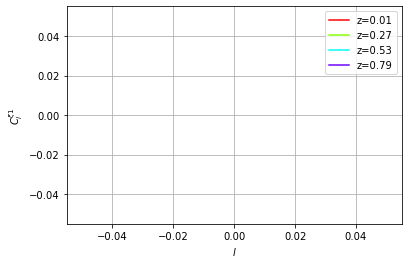

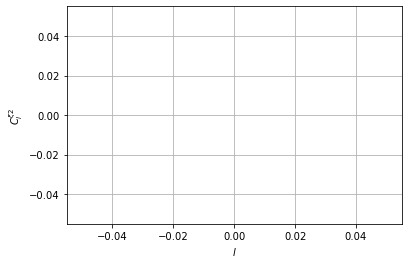

In [35]:
cmap = get_cmap(len(zindices)+1)
for i, zi in enumerate(zindices[:]):
    plt.plot(ell_list, Cell1h_list[i, :], color=cmap(i), label='z={:.2f}'.format(zs[zi]))
plt.xlabel(r'$l$'); plt.ylabel(r'$C_l^{\xi 1}$')
plt.legend(); plt.grid()
plt.savefig(dirplots+'cell1halo_lin.pdf')
plt.show()

for i, zi in enumerate(zindices):
    plt.plot(ell_list, Cell2h_list[i, :], color=cmap(i), label='z={:.2f}'.format(zs[zi]))
plt.xlabel(r'$l$'); plt.ylabel(r'$C_l^{\xi 2}$')
plt.grid()
plt.savefig(dirplots+'cell2halo_lin.pdf')
plt.show()

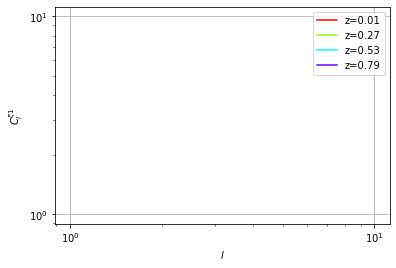

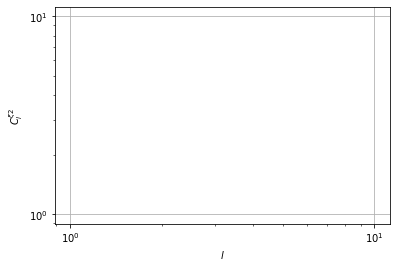

In [36]:
cmap = get_cmap(len(zindices)+1)
for i, zi in enumerate(zindices[:]):
    plt.loglog(ell_list, Cell1h_list[i, :], color=cmap(i), label='z={:.2f}'.format(zs[zi]))
plt.xlabel(r'$l$'); plt.ylabel(r'$C_l^{\xi 1}$')
plt.legend(); plt.grid()
plt.savefig(dirplots+'cell1halo_log.pdf')
plt.show()

for i, zi in enumerate(zindices):
    plt.loglog(ell_list, Cell2h_list[i, :], color=cmap(i), label='z={:.2f}'.format(zs[zi]))
plt.xlabel(r'$l$'); plt.ylabel(r'$C_l^{\xi 2}$')
plt.grid()
plt.savefig(dirplots+'cell2halo_log.pdf')
plt.show()

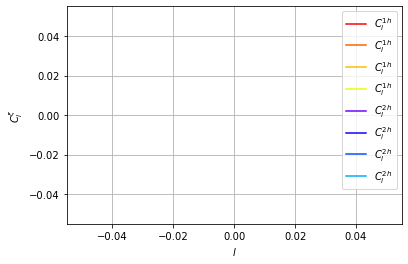

In [37]:
ct = 4*len(zindices)+1
cmap1 = get_cmap(ct)
cmap2 = get_cmap(ct)

for i, zi in enumerate(zindices):
    plt.plot(ell_list, Cell1h_list[i, :], color=cmap1(i), label=r'$C_l^{1h}$')#+', z={:.2f}'.format(zs[zi]))
for i, zi in enumerate(zindices):
    plt.plot(ell_list, Cell2h_list[i, :], color=cmap2(ct-len(zindices)-(i+1)), label=r'$C_l^{2h}$')#+', z={:.2f}'.format(zs[zi]))
plt.xlabel(r'$l$'); plt.ylabel(r'$C^\xi_l$')
plt.legend(); plt.grid()
plt.savefig(dirplots+'cellcomparisons_linear.pdf')
plt.show()

# the 2halo term is super amplified by the 10^5 order of magnitude matter angular PS

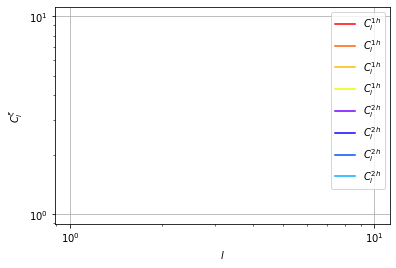

In [38]:
ct = 4*len(zindices)+1
cmap1 = get_cmap(ct)
cmap2 = get_cmap(ct)

for i, zi in enumerate(zindices):
    plt.loglog(ell_list, Cell1h_list[i, :], color=cmap1(i), label=r'$C_l^{1h}$')#+', z={:.2f}'.format(zs[zi]))
for i, zi in enumerate(zindices):
    plt.loglog(ell_list, Cell2h_list[i, :], color=cmap2(ct-len(zindices)-(i+1)), label=r'$C_l^{2h}$')#+', z={:.2f}'.format(zs[zi]))
plt.yscale('log'); plt.xscale('log')
plt.xlabel(r'$l$'); plt.ylabel(r'$C^\xi_l$')
plt.legend(); plt.grid()
plt.savefig(dirplots+'cellcomparisons_log.pdf')
plt.show()

# the 2halo term is super amplified by the 10^5 order of magnitude matter angular PS

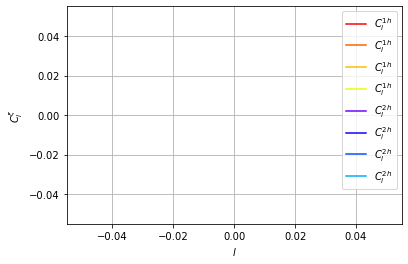

In [39]:
ct = 4*len(zindices)+1
cmap1 = get_cmap(ct)
cmap2 = get_cmap(ct)

for i, zi in enumerate(zindices):
    plt.plot(ell_list, np.sqrt((2.*ell+1)/(4.*np.pi)*Cell1h_list[i, :]), color=cmap1(i), label=r'$C_l^{1h}$')#+', z={:.2f}'.format(zs[zi]))
for i, zi in enumerate(zindices):
    plt.plot(ell_list, np.sqrt((2.*ell+1)/(4.*np.pi)*Cell2h_list[i, :]), color=cmap2(ct-len(zindices)-(i+1)), label=r'$C_l^{2h}$')#+', z={:.2f}'.format(zs[zi]))
plt.xlabel(r'$l$'); plt.ylabel(r'$C^\xi_l$')
plt.legend(); plt.grid()
plt.savefig(dirplots+'sqrtcellcomparisons_linear.pdf')
plt.show()

# the 2halo term is super amplified by the 10^5 order of magnitude matter angular PS

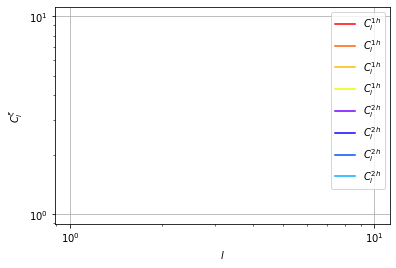

In [40]:
ct = 4*len(zindices)+1
cmap1 = get_cmap(ct)
cmap2 = get_cmap(ct)

for i, zi in enumerate(zindices):
    plt.loglog(ell_list, np.sqrt((2.*ell+1)/(4.*np.pi)*Cell1h_list[i, :]), color=cmap1(i), label=r'$C_l^{1h}$')#+', z={:.2f}'.format(zs[zi]))
for i, zi in enumerate(zindices):
    plt.loglog(ell_list, np.sqrt((2.*ell+1)/(4.*np.pi)*Cell2h_list[i, :]), color=cmap2(ct-len(zindices)-(i+1)), label=r'$C_l^{2h}$')#+', z={:.2f}'.format(zs[zi]))
plt.xlabel(r'$l$'); plt.ylabel(r'$C^\xi_l$')
plt.yscale('log'); plt.xscale('log')
plt.legend(); plt.grid()
plt.savefig(dirplots+'sqrtcellcomparisons_log.pdf')
plt.show()

# the 2halo term is super amplified by the 10^5 order of magnitude matter angular PS

No handles with labels found to put in legend.


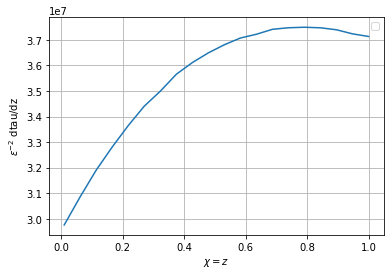

35219142.58647952


In [41]:
# Calculate and plot the differential optical depth and integrate to get the total optical depth.
ns = np.asarray([np.pi*np.trapz(rcross[zi,:]**2.*prob[zi,:]*nzm[zi,:], ms) for zi in range(nZs)])

dtaudz = ns*(1+zs)**2./hcos.h_of_z(zs)

plt.plot(zs, dtaudz)
plt.xlabel(r'$\chi=z$'); plt.ylabel('$\epsilon^{-2}$ dtau/dz')
plt.legend(); plt.grid()
plt.savefig(dirplots+'dtaudz.pdf')
plt.show()

tautot=np.trapz(ns*(1+zs)*(1+zs)/hcos.h_of_z(zs),zs)
print(tautot)

In [ ]:
if False:
    def add_darkphoton_profile(self,name,numeric=False,
                        nxs=None,
                        xmax=None,ignore_existing=False):

#        """
#        xmax should be thought of in "concentration units", i.e.,
#        for a cluster with concentration 3., xmax of 100 is probably overkill
#        since the integrals are zero for x>3. However, since we are doing
#        a single FFT over all profiles, we need to choose a single xmax.
#        xmax of 100 is very safe for m~1e9 msolar, but xmax of 200-300
#        will be needed down to m~1e2 msolar.
#        nxs is the number of samples from 0 to xmax of rho_nfw(x). Might need
#        to be increased from default if xmax is increased and/or going down
##        to lower halo masses.
#        xmax decides accuracy on large scales
#        nxs decides accuracy on small scales
#        
#        """
        if not(ignore_existing): assert name not in self.uk_profiles.keys(), "Profile name already exists."
        if nxs is None: nxs = self.p['nfw_integral_numxs']
        if xmax is None: xmax = self.p['nfw_integral_xmax']
        cs = self.concentration()
        ms = self.ms
        rvirs = self.rvir(ms[None,:],self.zs[:,None])
        rss = (rvirs/cs)[...,None]
        if numeric:
            ks,ukouts = generic_profile_fft(lambda x: rho_nfw_x(x,rhoscale=1),cs,rss,self.zs,self.ks,xmax,nxs)
            self.uk_profiles[name] = ukouts.copy()
        else:
            cs = cs[...,None]
            mc = np.log(1+cs)-cs/(1.+cs)
            x = self.ks[None,None]*rss *(1+self.zs[:,None,None])# !!!!
            Si, Ci = scipy.special.sici(x)
            Sic, Cic = scipy.special.sici((1.+cs)*x)
            ukouts = (np.sin(x)*(Sic-Si) - np.sin(cs*x)/((1+cs)*x) + np.cos(x)*(Cic-Ci))/mc
            self.uk_profiles[name] = ukouts.copy()
        
        return self.ks,ukouts